# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [143]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import tree 

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


## Load Data

In [144]:
# Load the data
data_dir = './WStage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tour_detail = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_reg_compact = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_reg_detail = pd.read_csv(data_dir + 'WRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
df_teams_leagues = pd.merge(left=df_teams, right=pd.read_csv(data_dir + 'WLeagues.csv'), how='left', on=['TeamName'])


### Get Matchups of interest for Training & Test Data

In [145]:
## Get 2018 data - update for Charlene's fine

# sorting ensures that we work through smallest to largest 
# no repeats, smallest always first in pair
current_year = df_seeds[df_seeds['Season'] == 2018].sort_values(by=['TeamID'])
current_year_pairs = list(it.combinations(current_year['TeamID'],2))

team1, team2 = map(list, zip(*current_year_pairs))

df_test_pairs = pd.DataFrame({
    'Season' : [2018] * len(team1),
    'Team1' : team1,
    'Team2' : team2
})

In [146]:
# this gives us test pairings! Season, Team1, Team2
df_test_pairs.head()

,Season,Team1,Team2
0,2018,3110,3113
1,2018,3110,3114
2,2018,3110,3124
3,2018,3110,3125
4,2018,3110,3129


In [147]:
# also need previous matchups (1998 - 2017)
df_train_pairs = pd.DataFrame(
    { 'Team1' : df_tour_compact['WTeamID'],
     'Team2' : df_tour_compact['LTeamID'],
     'Season' : df_tour_compact['Season']
    })

df_train_pairs.tail()

,Season,Team1,Team2
1255,2017,3163,3332
1256,2017,3376,3199
1257,2017,3280,3163
1258,2017,3376,3390
1259,2017,3376,3280


In [148]:
# this is what we will use as a base to build our dataset
df_train_test_matchups = df_train_pairs.append(df_test_pairs)

## Feature Engineering for Training & Test Data

### Current Year Seeds

In [149]:
# get just integer value of seed (exclude region information)
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['SeedInt'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [150]:
# merge seeds with team IDs for tourney performance
df_W = df_seeds.rename(columns={'TeamID':'Team1', 'SeedInt':'Team1Seed'})
df_L = df_seeds.rename(columns={'TeamID':'Team2', 'SeedInt':'Team2Seed'})
df_dummy = pd.merge(left=df_train_test_matchups, right=df_W, how='left', on=['Season', 'Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Season', 'Team2'])

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed
3271,2018,3437,3443,9,11
3272,2018,3437,3453,9,7
3273,2018,3438,3443,10,11
3274,2018,3438,3453,10,7
3275,2018,3443,3453,11,7


### Current Year Seed Difference

In [151]:
# negative number indicates that team 2 (loser, in this case) has higher seed
df_matchups['SeedDiff'] = df_matchups['Team2Seed'].sub(df_matchups['Team1Seed'], axis=0)

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff
3271,2018,3437,3443,9,11,2
3272,2018,3437,3453,9,7,-2
3273,2018,3438,3443,10,11,1
3274,2018,3438,3453,10,7,-3
3275,2018,3443,3453,11,7,-4


### Last Year's Tournament Seed 

In [152]:
# what to do for games where we had no previous year (1998)?

# add 1 so easily referenced
df_prev_seeds = pd.DataFrame({
    'TeamID' : df_seeds['TeamID'],
    'SeedInt' : df_seeds['SeedInt'],
    'Season' : df_seeds['Season'].apply(lambda x: x + 1)
})

In [153]:
df_W = df_prev_seeds.rename(columns={'TeamID':'Team1','SeedInt':'Team1PrevSeed'})
df_L = df_prev_seeds.rename(columns={'TeamID':'Team2','SeedInt':'Team2PrevSeed'})
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Season', 'Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Season', 'Team2'])

## what to do if they weren't in the tournament last year (17?)
df_matchups = df_matchups.fillna(value=17)

df_matchups.head()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed
0,1998,3104,3422,2,15,13,17.0,17.0
1,1998,3112,3365,3,14,11,17.0,17.0
2,1998,3163,3193,2,15,13,17.0,17.0
3,1998,3198,3266,7,10,3,17.0,17.0
4,1998,3203,3208,10,7,-3,17.0,17.0


### Average Tournament Seed & Games Won Over Past X Years

In [154]:
# this indicates how far back we want to go
# don't have to worry about missing data if we're not starting until 2010
hist = 2.0

In [155]:
w_seed_hist = []
l_seed_hist = []

w_game_hist = []
l_game_hist = []

# for each one, get past X years of tourney seeds
for i,r in df_matchups.iterrows():
    w_team_apps =  df_seeds[(df_seeds['TeamID'] == r['Team1'])] #all apps for this team
    # recent appearances (does not include current year)
    w_team_recent_apps = w_team_apps[(w_team_apps['Season'] >= (r['Season'] - hist)) & (w_team_apps['Season'] < r['Season'])]
    
    # all wins for this team - this takes advantage of the fact that we're currently organized 
    w_wins = df_matchups[(df_matchups['Team1'] == r['Team1'])]
    w_recent_wins = w_wins[(w_wins['Season'] >= (r['Season'] - hist)) & (w_wins['Season'] < r['Season'])]

    # take into account years they weren't in the tournament, penalizes for that (approx. seed = 17)
    w_avg_seed = (w_team_recent_apps['SeedInt'].sum() + (((hist) - len(w_team_recent_apps)) * 17)) / float(hist)
    
    # not making it recently is same as making it and losing 
    if len(w_team_recent_apps) == 0:
        w_avg_games = 0
    else:
        w_avg_games = (len(w_recent_wins)) / hist

    w_game_hist.append(round(w_avg_games,2))
    w_seed_hist.append(round(w_avg_seed,2))
    
    l_team_apps =  df_seeds[(df_seeds['TeamID'] == r['Team2'])]
    l_team_recent_apps = l_team_apps[(l_team_apps['Season'] >= (r['Season'] - hist)) & (l_team_apps['Season'] < r['Season'])]
    
    l_wins = df_matchups[(df_matchups['Team1'] == r['Team2'])]
    l_recent_wins = l_wins[(l_wins['Season'] >= (r['Season'] - hist)) & (l_wins['Season'] < r['Season'])]

    # take into account years they weren't in the tournament, penalizes for that (approx. seed = 17)
    l_avg_seed = (l_team_recent_apps['SeedInt'].sum() + (((hist) - len(l_team_recent_apps)) * 17)) / float(hist)
    if len(l_team_recent_apps) == 0:
        l_avg_games = 0
    else:
        l_avg_games = (len(l_recent_wins)) / hist
    
    l_game_hist.append(round(l_avg_games,2))
    l_seed_hist.append(round(l_avg_seed,2))


df_matchups['Team1AvgSeed'] = w_seed_hist
df_matchups['Team2AvgSeed'] = l_seed_hist
df_matchups['Team1AvgGames'] = w_game_hist
df_matchups['Team2AvgGames'] = l_game_hist

# for now, inspect the tail 
df_matchups.tail(10)

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames
3266,2018,3417,3437,3,9,6,4.0,17.0,3.5,17.0,2.0,0.0
3267,2018,3417,3438,3,10,7,4.0,17.0,3.5,17.0,2.0,0.0
3268,2018,3417,3443,3,11,8,4.0,12.0,3.5,14.5,2.0,0.0
3269,2018,3417,3453,3,7,4,4.0,8.0,3.5,9.0,2.0,0.0
3270,2018,3437,3438,9,10,1,17.0,17.0,17.0,17.0,0.0,0.0
3271,2018,3437,3443,9,11,2,17.0,12.0,17.0,14.5,0.0,0.0
3272,2018,3437,3453,9,7,-2,17.0,8.0,17.0,9.0,0.0,0.0
3273,2018,3438,3443,10,11,1,17.0,12.0,17.0,14.5,0.0,0.0
3274,2018,3438,3453,10,7,-3,17.0,8.0,17.0,9.0,0.0,0.0
3275,2018,3443,3453,11,7,-4,12.0,8.0,14.5,9.0,0.0,0.0


### Last Year's Tournament Performance 

### League Competitiveness

In [156]:
# don't overwrite training dataset!
df_tour_hist = df_matchups

In [157]:
#
winning_games_w = df_tour_hist.groupby('Team1').count().reset_index()[['Team1','Season']].rename(columns={'Season':'WWins'})
winning_games_l = df_tour_hist.groupby('Team1').count().reset_index()[['Team1','Season']].rename(columns={'Season':'LWins','Team1':'Team2'})

losing_games_w = df_tour_hist.groupby('Team2').count().reset_index()[['Team2','Season']].rename(columns={'Season':'WLosses','Team2':'Team1'})
losing_games_l = df_tour_hist.groupby('Team2').count().reset_index()[['Team2','Season']].rename(columns={'Season':'LLosses'})

# get total tournament games - all games, could be more than 1 appearance per year
df_total_apps = pd.merge(left=df_tour_hist, right=winning_games_w, how='left', on=['Team1']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=winning_games_l, how='left', on=['Team2']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_w, how='left', on=['Team1']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_l, how='left', on=['Team2']).fillna(0)


df_total_apps['WTotGames'] = df_total_apps['WWins'] + df_total_apps['WLosses']
df_total_apps['WPctWins'] = df_total_apps['WWins'] / df_total_apps['WTotGames'] 

df_total_apps['LTotGames'] = df_total_apps['LWins'] + df_total_apps['LLosses']
df_total_apps['LPctWins'] = df_total_apps['LWins'] / df_total_apps['LTotGames'] 

# This now includes: 
df_total_apps.head()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames,WWins,LWins,WLosses,LLosses,WTotGames,WPctWins,LTotGames,LPctWins
0,1998,3104,3422,2,15,13,17.0,17.0,17.0,17.0,0.0,0.0,3,0.0,2,1,5,0.600000,1.0,0.000000
1,1998,3112,3365,3,14,11,17.0,17.0,17.0,17.0,0.0,0.0,5,0.0,6,4,11,0.454545,4.0,0.000000
2,1998,3163,3193,2,15,13,17.0,17.0,17.0,17.0,0.0,0.0,147,0.0,19,2,166,0.885542,2.0,0.000000
3,1998,3198,3266,7,10,3,17.0,17.0,17.0,17.0,0.0,0.0,2,38.0,3,35,5,0.400000,73.0,0.520548
4,1998,3203,3208,10,7,-3,17.0,17.0,17.0,17.0,0.0,0.0,53,70.0,30,38,83,0.638554,108.0,0.648148


In [158]:
# determine 'competitiveness of league' 
## What teams have good win percentages
df_win_apps = df_total_apps.rename(columns={'WPctWins' : 'PctWins','Team1' : 'TeamID', 'WTotGames': 'TotGames'})
df_loss_apps = df_total_apps.rename(columns={'LPctWins' : 'PctWins', 'Team2' : 'TeamID', 'LTotGames': 'TotGames'})

df_apps = df_win_apps[['PctWins','TeamID','TotGames']].append(df_loss_apps[['PctWins','TeamID','TotGames']])
df_apps = df_apps.drop_duplicates()

## This means that a lot of these have never been to the tournament - makes sense
#plt.hist(df_apps['PctWins'],bins=10)

# Maybe need to filter for just teams that are currently in tourney
#l = df_seeds.loc[df_seeds['Season'] == 2018]
#plt.hist((df_apps[df_apps['TeamID'].isin(l['TeamID'])])['PctWins'],bins=10)

In [159]:
df_teams_leagues.head()

,TeamID,TeamName,LeagueName
0,3101,Abilene Chr,Southland
1,3102,Air Force,MWC
2,3103,Akron,MAC
3,3104,Alabama,SEC
4,3105,Alabama A&M,SWAC


In [160]:
# Merge Performance Stats with league info
df_league_pct = pd.merge(left=df_apps, right = df_teams_leagues, how='left', on=['TeamID'])

# group by league to see how leagues perform
df_league_perf = df_league_pct.groupby('LeagueName')['PctWins'].mean().reset_index()

df_league_perf.head()

,LeagueName,PctWins
0,AAC,0.227926
1,ACC,0.501126
2,ASUN,0.172794
3,America East,0.237395
4,Atlantic 10,0.323755


In [161]:
df_teams_leagues = pd.merge(left=df_teams_leagues,right = df_league_perf, how='left', on=['LeagueName'])
df_teams_leagues.head()

,TeamID,TeamName,LeagueName,PctWins
0,3101,Abilene Chr,Southland,0.084656
1,3102,Air Force,MWC,0.299423
2,3103,Akron,MAC,0.231940
3,3104,Alabama,SEC,0.507880
4,3105,Alabama A&M,SWAC,0.090110


#### Add this to our training dataset

In [162]:
df_W = df_teams_leagues[['TeamID','PctWins']].rename(columns={'TeamID':'Team1', 'PctWins' : "Team1LeaguePerf"})
df_L = df_teams_leagues[['TeamID','PctWins']].rename(columns={'TeamID':'Team2', 'PctWins' : "Team2LeaguePerf"})

In [163]:
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Team2'])

df_matchups['LeaguePerfDiff'] = df_matchups['Team1LeaguePerf'] - df_matchups['Team2LeaguePerf']
df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames,Team1LeaguePerf,Team2LeaguePerf,LeaguePerfDiff
3271,2018,3437,3443,9,11,2,17.0,12.0,17.0,14.5,0.0,0.0,0.454189,0.282576,0.171613
3272,2018,3437,3453,9,7,-2,17.0,8.0,17.0,9.0,0.0,0.0,0.454189,0.067320,0.386869
3273,2018,3438,3443,10,11,1,17.0,12.0,17.0,14.5,0.0,0.0,0.501126,0.282576,0.218550
3274,2018,3438,3453,10,7,-3,17.0,8.0,17.0,9.0,0.0,0.0,0.501126,0.067320,0.433806
3275,2018,3443,3453,11,7,-4,12.0,8.0,14.5,9.0,0.0,0.0,0.282576,0.067320,0.215255


### LAST: Generate negative examples + Split into training (train + dev) and test

In [164]:
## Resolve this!! - for now, drop 1998 because we don't have a previous year
df_matchups = df_matchups[(df_matchups['Season'] > 1998) & (df_matchups['Season'] < 2018)]

# test data only
x_test = df_matchups[df_matchups['Season'] == 2018]

In [165]:
# Generate negative examples - update depending on columns used

df_neg = pd.DataFrame(
{
    'Season' : df_matchups['Season']  ,
    'SeedDiff' : -df_matchups['SeedDiff'],
    'Team1' : df_matchups['Team2']  ,
    'Team1Seed' : df_matchups['Team2Seed']  ,
    'Team1PrevSeed' : df_matchups['Team2PrevSeed']  ,
    'Team1LeaguePerf' : df_matchups['Team2LeaguePerf']  ,
    'Team2' : df_matchups['Team1']  ,
    'Team2Seed' : df_matchups['Team1Seed']  ,
    'Team2PrevSeed' : df_matchups['Team1PrevSeed']  ,
    'Team2LeaguePerf' : df_matchups['Team1LeaguePerf']  ,
    'LeaguePerfDiff' : - df_matchups['LeaguePerfDiff'] ,
    'Team1AvgSeed' : df_matchups['Team2AvgSeed'] ,
    'Team2AvgSeed' : df_matchups['Team1AvgSeed'] ,
    'Team1AvgGames' : df_matchups['Team2AvgGames'] ,
    'Team2AvgGames' : df_matchups['Team1AvgGames']

})

In [184]:
# include positive and negative examples from 1999 - 2017 (for now)
x_train = df_matchups.append(df_neg)

In [185]:
# build outcome = first 1/2 of data is positive, second 1/2 is negative 
y_train = ([1] * len(df_matchups)) + ([0] * len(df_matchups))

### Play Around with Feature Selection

#### Add/remove as needed; don't forget to do this for test and train

In [186]:
# Drop features as interested

## Baseline
#x_final_train = x_train[['SeedDiff']]

## Testing
#x_final_train = x_train
x_final_train = x_train.drop(labels=['Team1','Team2','Team2LeaguePerf','Team1LeaguePerf'],axis=1)

In [189]:
# Split into train and dev
train_x, dev_x, train_y, dev_y = train_test_split(x_final_train,y_train)

In [190]:
train_x.head()

,LeaguePerfDiff,Season,SeedDiff,Team1AvgGames,Team1AvgSeed,Team1PrevSeed,Team1Seed,Team2AvgGames,Team2AvgSeed,Team2PrevSeed,Team2Seed
1257,-0.279954,2017,1,6.0,1.0,1.0,1,1.5,5.0,5.0,2
442,0.306612,2005,13,1.0,10.5,4.0,2,0.0,17.0,17.0,15
558,0.053787,2006,3,1.5,2.5,1.0,1,1.5,5.5,9.0,4
209,0.433806,2001,15,3.5,2.5,2.0,1,0.0,17.0,17.0,16
1233,-0.060540,2017,-1,1.5,4.0,3.0,5,1.5,2.5,3.0,4


### Build Model

In [191]:
## Fit a logistic regression model through grid search
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(train_x, train_y)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4454, with best C: 0.01


In [192]:
lr = LogisticRegression()

lr.fit(train_x,train_y)
metrics.log_loss(train_y,lr.predict_proba(train_x))

0.4410523434518494

In [193]:
dt = tree.DecisionTreeRegressor()

dt.fit(train_x,train_y)
metrics.log_loss(train_y,lr.predict_proba(train_x))

0.4410523434518494

In [194]:
gnb = GaussianNB()

gnb.fit(train_x,train_y)
metrics.log_loss(train_y,gnb.predict_proba(train_x))

0.97951047122568724

In [195]:
bnb = BernoulliNB()

bnb.fit(train_x,train_y)
metrics.log_loss(train_y,bnb.predict_proba(train_x))

0.54902881003143889

### Examine Errors
#### what do we make mistakes on?

0.128140703518
398


/Users/juliabuffinton/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(array([ 18.,  11.,   1.,  26.,   6.,  50.,  74.,  19.,  77.,   3.,  49.,
         28.,   1.,  13.,  22.]),
 array([-9. , -7.8, -6.6, -5.4, -4.2, -3. , -1.8, -0.6,  0.6,  1.8,  3. ,
         4.2,  5.4,  6.6,  7.8,  9. ]),
 <a list of 15 Patch objects>)

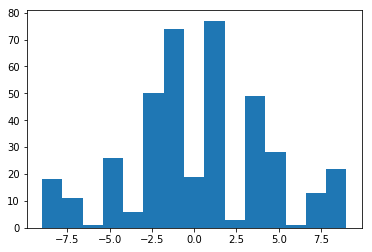

In [206]:
# Logistic Regression
errors = ((np.where(train_y != lr.predict(train_x)))[0]).tolist()

train_errors = train_x.iloc[errors]

bad_preds = [train_y[i] for i in errors]

train_errors['Predictions'] = bad_preds

# interestingly, looks like a lot of our errors are when the seed difference is small
print train_errors['SeedDiff'].mean()

print len(train_errors)

plt.hist(x=train_errors['SeedDiff'],bins=15)

## FROM BASELINE SUBMISSION - EDIT/REMOVE THIS

In [30]:
## Fit a logistic regression model through grid search

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(train_x, train_y)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5097, with best C: 0.001


In [31]:
## Make predictions
preds = clf.predict_proba(train_x)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
clipped_preds

array([ 0.62456812,  0.65422996,  0.35796356, ...,  0.09473379,
        0.70569841,  0.65212157])

In [32]:
type(train_x)

pandas.core.frame.DataFrame

In [33]:
#pd.X

In [34]:
#np.arange(-10, 10).reshape(-1, 1)

In [35]:
#preds

In [36]:
#X

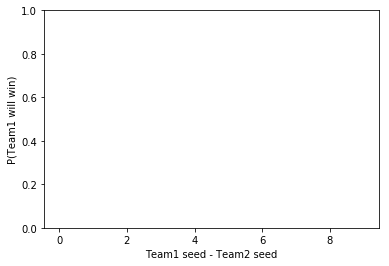

In [37]:
## Plot to confirm intuition that greater positive seed difference indicates higher win probability
X = np.arange(0, 10).reshape(1, -1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')
plt.ylim(0, 1)
plt.show()

In [38]:
#df_sample_sub.to_csv('test-submission.csv', index=False)

## Evaluation

In [39]:
#Suggest to move go the fiirst coding unite
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

### Log Loss

- Log Loss is the most important classification metric based on probabilities. It is also a key way of evaluation of our prediction from Kaggle NCAA page. 
- It is also called the Log Likelihood Function. The log of the likelihood that the 2018 tournament bracket actually happens based on our prediction of wining probability of each team matchups.

$$
LogLoss = \sum_{i=1}^{n} [y_i log(\hat{y_i})+(1-y_i) log(1-\hat{y_i})]
$$

- The result will be a negative number that's in a range computers keep track of. However, Scikit-learn has a conventin in its metrics that lower scores are better. 
    - So, scikit-learn report $$-1* \frac{LogLoss}{NumObservations}$$
    
$$
LogLoss = -\frac{1}{n} \sum_{i=1}^{n} [y_i log(\hat{y_i})+(1-y_i) log(1-\hat{y_i})]
$$
    
    The division by the number of datapoints is used so the range of values doesn't systematically vary with the dataset size. 
    - The rage of that is 0 to infinit. 
    - The lower the metrix is, the better model performance is.
- Log loss penalizes both types of errors, but especially those predications that are confident and wrong.

In [40]:
df_sub = pd.read_csv('WSampleSubmissionStage2.csv')
df_result = pd.read_csv('NCAA_Result_2018.csv')
df_eval = df_result.merge(df_sub, left_on='ID', right_on='ID', how='left')
df_eval.head()

,ID,Result,Pred
0,2018_3163_3384,1,0.5
1,2018_3274_3346,0,0.5
2,2018_3125_3181,0,0.5
3,2018_3208_3273,1,0.5
4,2018_3138_3378,1,0.5


In [41]:
y_pred = df_eval.loc[:,'Pred'].as_matrix()
y_true = df_eval.loc[:,'Result'].as_matrix()
log_loss(y_true, y_pred, eps=1e-15)

0.69314718055994551

In our case, the Log Loss value is ......

### Accuracy

Accuracy measures a fraction of the classifier's predictions that are correct.

In [42]:
df_eval['Pred_b'] = np.where(df_eval['Pred']>=0.5, 1, 0) 
df_eval.head()

,ID,Result,Pred,Pred_b
0,2018_3163_3384,1,0.5,1
1,2018_3274_3346,0,0.5,1
2,2018_3125_3181,0,0.5,1
3,2018_3208_3273,1,0.5,1
4,2018_3138_3378,1,0.5,1


In [43]:
y_pred_b = df_eval.loc[:,'Pred_b'].as_matrix()
y_true = df_eval.loc[:,'Result'].as_matrix()

In [44]:
accuracy_score(y_true, y_pred_b)

0.53968253968253965

In our case, the accuracy score is ...

### F1 measure with Cross Validation

- **Precision** is the fraction of positive predictions that are correct, which means the team who we predicts as winner that are actually winner. 
    - (TP = True Positive, FP = False Positive)

$$ P = \frac{TP}{TP+FP}$$


- **Recall**, the true positive rate, is the fraction of the truly positive instances that the classifier recognizes. A recall score of one indicates that the classifier did not make any false negative predictions.
In our case, recall is the fraction of winner team that were truly classified as winner, according to our prediction of winning proberbility. 
    - (TP = True Positive, FN = False Negative)
    
$$ P = \frac{TP}{TP+FN}$$

In [45]:
precisions = cross_val_score(logreg, train_x, train_y, cv=5, scoring='precision')
print ('Precision', np.mean(precisions), precisions)

recalls = cross_val_score(logreg, train_x, train_y, cv=5, scoring='recall')
print ('Recalls', np.mean(recalls), recalls)

Precision 0.774215197293 [ 0.7703252   0.79324895  0.77593361  0.76171079  0.76985743]
Recalls 0.774617962751 [ 0.77983539  0.77160494  0.77113402  0.77113402  0.77938144]


In our case, the precision and recalls are...

- The **F1 measure** is the harmonic mean, or weighted average, of the precision and recall scores. Also called the f-measure or the f-score. 
    - (P = precision, R = recall) 
    $$ F1 = 2 \frac{PR}{P+R}$$

    
- The F1 measure penalizes classifiers with imbalanced precision and recall scores, like the trivial classifier that always predicts the positive class. 
- A model with perfect precision and recall scores will achieve an F1 score of 1. A model with a perfect precision score and a recall score of zero will achieve an F1 score of 0.
- Models are sometimes evaluated using the F0.5 and F2 scores, which favor precision over recall and recall over precision, respectively.

In [46]:
f1s = cross_val_score(logreg, train_x, train_y, cv=5, scoring='f1')
print ('F1', np.mean(f1s), f1s)

F1 0.77457888697 [ 0.77505112  0.78333333  0.77352637  0.76639344  0.77459016]


In our case, the arithmetic mean of our classifier's precision and recall scores is 0.77. As the difference between the classifier's precision and recall is small, the F1 measure's penalty is small. 

### ROC Curve

- Receiver Operating Characteristic, or ROC curve, visualizes a classifier's performance.
- ROC curve illustrates the classifier's performance for all values of the discrimination threshold. 
    - The true positive rate (Sensitivity, Recall ) is plotted in function of the false positive rate (100-Specificity, Fall-out) for different cut-off points. 
    - Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. 
- AUC is the area under the ROC curve; it reduces the ROC curve to a single value, which represents the expected performance of the classifier. 
- The dashed line in the following figure is for a classifier that predicts classes randomly; it has an AUC of 0.5. The solid curve is for a classifier that outperforms random guessing.
- A test with perfect discrimination (no overlap in the two distributions) has a ROC curve that passes through the upper left corner (100% sensitivity, 100% specificity). Therefore the closer the ROC curve is to the upper left corner, the higher the overall accuracy of the test (Zweig & Campbell, 1993)

https://www.medcalc.org/manual/roc-curves.php

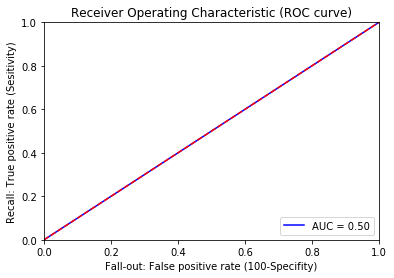

In [47]:
false_positive_rate, recall, thresholds = roc_curve(y_true,
y_pred)
roc_auc = auc(false_positive_rate, recall)


plt.title('Receiver Operating Characteristic (ROC curve)')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' %
roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall: True positive rate (Sesitivity)')
plt.xlabel('Fall-out: False positive rate (100-Specifity)')
plt.show()

In our case, the ROC curve ......

### Evaluation Summary

After checking Log Loss, Accuracy, Precision and recall, F1 measure, and ROC Curve, the model....

## Deployment

- How is the model deployed?
  - prediction service?
  - serialized model?
  - regression coefficients?
- What support is provided after initial deployment?